In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import pandas as pd
from scipy.special import logit, expit

In [2]:
import KECENI

In [3]:
from true_model import mu, pij, rX

# save directory and random seed

In [4]:
save_dir = 'data'

In [5]:
np.random.seed(12345)

# parameters

In [6]:
n_sim = 200
n_node = 1000
d_latent = 2
rho = 1.0

# latent position and network

In [7]:
Zs = np.random.uniform(-1, 1, (n_node, d_latent))

In [8]:
Zs, Zs.shape

(array([[ 0.85923219, -0.36724889],
        [-0.63216238, -0.59087944],
        [ 0.13545006,  0.19108941],
        ...,
        [ 0.73805685, -0.00366734],
        [ 0.19502467,  0.08711954],
        [ 0.89604713,  0.25790161]]),
 (1000, 2))

In [9]:
# P = np.exp(-2-80*np.max(np.abs(Zs[:,None,:] - Zs[None,:,:])**2, axis=-1))
P = np.exp(- np.exp(10*np.max(np.abs(Zs[:,None,:] - Zs[None,:,:]), axis=-1)))

In [10]:
P, P.shape

(array([[3.67879441e-001, 0.00000000e+000, 0.00000000e+000, ...,
         3.35741841e-017, 0.00000000e+000, 4.90959953e-226],
        [0.00000000e+000, 3.67879441e-001, 0.00000000e+000, ...,
         0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
        [0.00000000e+000, 0.00000000e+000, 3.67879441e-001, ...,
         1.46475582e-180, 5.91094491e-002, 0.00000000e+000],
        ...,
        [3.35741841e-017, 0.00000000e+000, 1.46475582e-180, ...,
         3.67879441e-001, 7.65857032e-100, 1.14897109e-006],
        [0.00000000e+000, 0.00000000e+000, 5.91094491e-002, ...,
         7.65857032e-100, 3.67879441e-001, 0.00000000e+000],
        [4.90959953e-226, 0.00000000e+000, 0.00000000e+000, ...,
         1.14897109e-006, 0.00000000e+000, 3.67879441e-001]]),
 (1000, 1000))

In [11]:
ths = np.random.random((n_node, n_node))

In [12]:
Adj = (ths <= rho * P).astype(int)
Adj[np.arange(n_node), np.arange(n_node)] = 0
Adj = np.logical_or(Adj, Adj.T)

In [13]:
# Adj = np.random.binomial(1, P, (n_node, n_node))
# Adj[np.arange(n_node), np.arange(n_node)] = 0
# Adj = np.logical_or(Adj, Adj.T)

In [14]:
degree = np.sum(Adj, 0)

(array([ 37., 122., 182., 214., 186., 108., 100.,  33.,  12.,   4.,   1.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
        10.5]),
 <BarContainer object of 11 artists>)

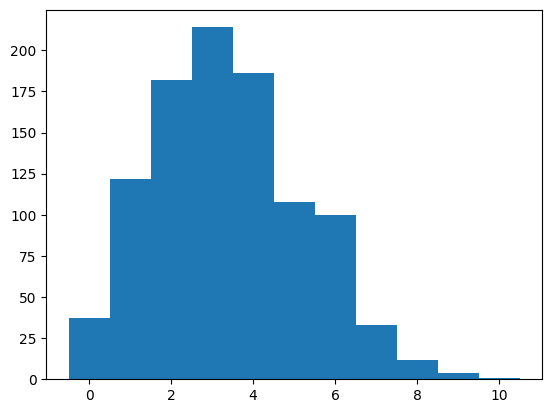

In [15]:
plt.hist(degree, np.arange(np.max(degree)+1)-0.5)

In [16]:
id_cntr = np.argmin(np.where(degree == 4, np.max(np.abs(Zs), -1), np.inf)); id_cntr

17

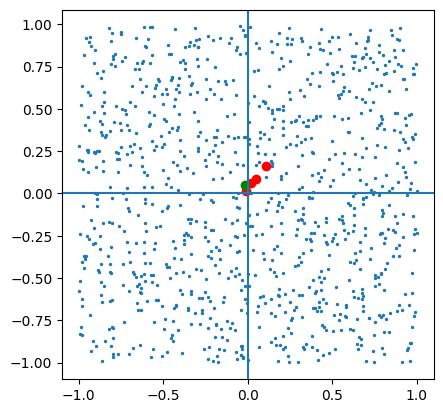

In [17]:
plt.gca().set_aspect('equal')
plt.scatter(*Zs.T, s=2)
plt.scatter(*Zs[Adj[id_cntr]==1].T, color='red')
plt.scatter(*Zs[id_cntr], color='green')
plt.axhline(y=0); plt.axvline(x=0)

In [18]:
G = KECENI.Graph(Adj, Zs)

In [19]:
row, col = np.where(Adj != 0)

Text(0, 0.5, '$Z_{i2}$')

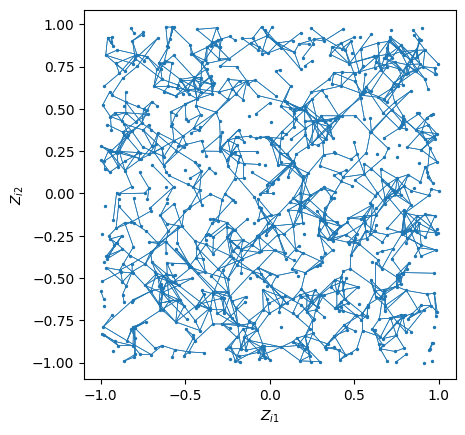

In [20]:
plt.gca().set_aspect('equal')
plt.scatter(*Zs.T, s=2)

for i, (r,c) in enumerate(zip(row, col)):
    plt.plot(*Zs[[r,c]].T, color='C0', linewidth=0.5)
    
plt.xlabel(r'$Z_{i1}$'); plt.ylabel(r'$Z_{i2}$')

In [21]:
data_latent = pd.DataFrame({'Z1': Zs[:,0], 'Z2': Zs[:,1]})
data_network = pd.DataFrame({'row': row+1, 'col': col+1})

In [22]:
data_latent.to_feather('%s/latent.feather'%save_dir)
data_network.to_feather('%s/network.feather'%save_dir)

# features

In [23]:
for i_sim in np.arange(n_sim):
    Xs = rX(1, np.arange(n_node), G)[0]
    
    ps = np.array([
        pij(1, Xs[G.N1(i)], G.sub(G.N1(i))) 
        for i in np.arange(n_node)
    ])
    
    Ts = np.random.binomial(1, ps) 
    
    ms = np.array([
        mu(Ts[G.N1(i)], Xs[G.N2(i)], G.sub(G.N2(i))) 
        for i in np.arange(n_node)
    ])
    
    Ys = np.random.normal(ms, 1)
    
    data_feature = pd.DataFrame({
        'X1': Xs[:,0], 'X2': Xs[:,1], 'X3': Xs[:,2],
        'p': ps, 'T': Ts, 'm': ms, 'Y': Ys
    })
    
    data_feature.to_feather(
        '%s/feature_%.3d.feather'%(save_dir, i_sim)
    )

# check

In [24]:
i_sim = 0

In [25]:
data_feature = pd.read_feather(
    '%s/feature_%.3d.feather'%(save_dir, i_sim)
)

(array([ 19.,  60.,  93., 162., 157., 159., 149., 111.,  65.,  25.]),
 array([0.04596727, 0.13531899, 0.2246707 , 0.31402242, 0.40337413,
        0.49272585, 0.58207756, 0.67142928, 0.76078099, 0.85013271,
        0.93948443]),
 <BarContainer object of 10 artists>)

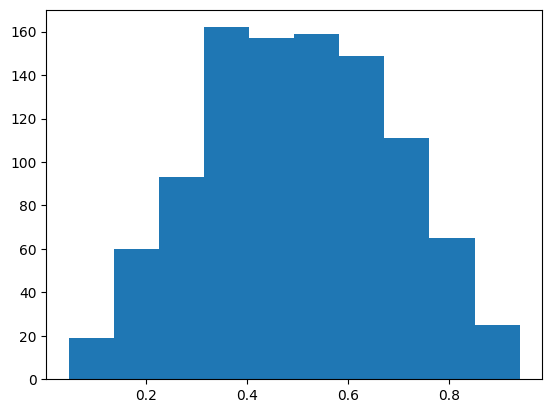

In [26]:
plt.hist(data_feature['p'])

In [27]:
np.mean(data_feature['T'])

0.468

(array([  5.,  26.,  81., 246., 331., 211.,  75.,  22.,   2.,   1.]),
 array([-10.72370356,  -8.33618037,  -5.94865718,  -3.56113398,
         -1.17361079,   1.2139124 ,   3.6014356 ,   5.98895879,
          8.37648198,  10.76400518,  13.15152837]),
 <BarContainer object of 10 artists>)

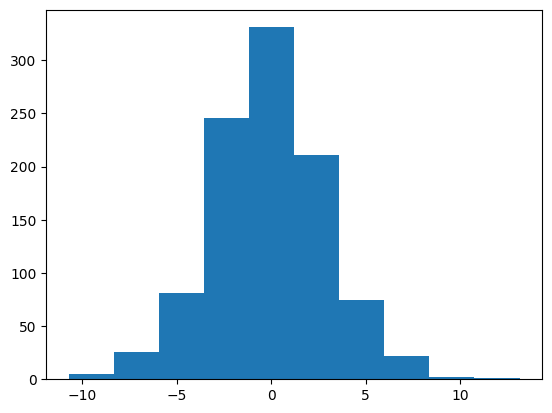

In [28]:
plt.hist(data_feature['Y'])

(array([ 12.,  32.,  90., 150., 100.,  51.,  24.,   7.,   1.,   1.]),
 array([-8.24896305, -6.10891391, -3.96886477, -1.82881563,  0.31123352,
         2.45128266,  4.5913318 ,  6.73138094,  8.87143009, 11.01147923,
        13.15152837]),
 <BarContainer object of 10 artists>)

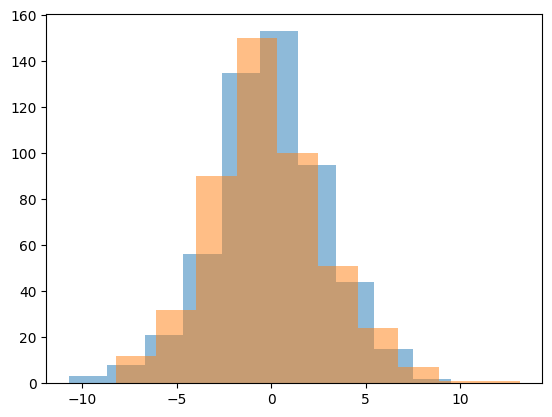

In [29]:
plt.hist(data_feature.query('T == 0')['Y'], alpha=0.5)
plt.hist(data_feature.query('T == 1')['Y'], alpha=0.5)

In [30]:
np.mean(data_feature.query('T == 0')['Y']), np.mean(data_feature.query('T == 1')['Y'])

(-0.07335025477342251, -0.20262335504031626)

(array([  4.,  20.,  47.,  72.,  97., 101.,  72.,  31.,  16.,   8.]),
 array([-2.2782913 , -1.7637055 , -1.2491197 , -0.73453389, -0.21994809,
         0.29463771,  0.80922351,  1.32380931,  1.83839512,  2.35298092,
         2.86756672]),
 <BarContainer object of 10 artists>)

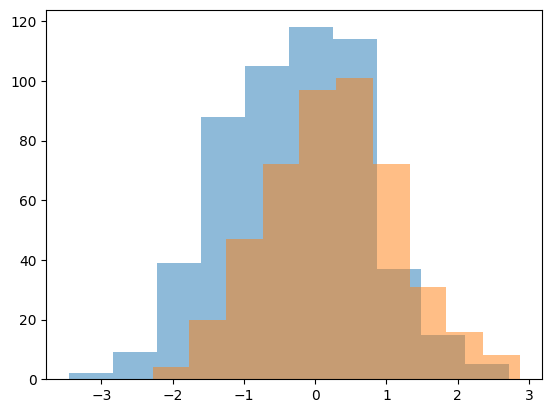

In [31]:
plt.hist(data_feature.query('T == 0')['X1'], alpha=0.5)
plt.hist(data_feature.query('T == 1')['X1'], alpha=0.5)

(array([  4.,  17.,  39.,  46., 102., 129.,  74.,  33.,  16.,   8.]),
 array([-2.73097418, -2.14871614, -1.5664581 , -0.98420007, -0.40194203,
         0.18031601,  0.76257405,  1.34483209,  1.92709013,  2.50934816,
         3.0916062 ]),
 <BarContainer object of 10 artists>)

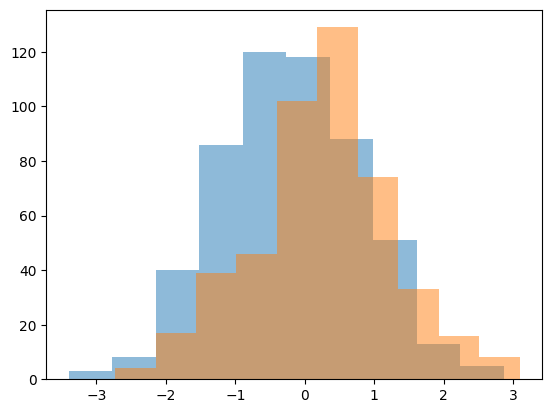

In [32]:
plt.hist(data_feature.query('T == 0')['X2'], alpha=0.5)
plt.hist(data_feature.query('T == 1')['X2'], alpha=0.5)

(array([  3.,  13.,  43.,  73.,  95., 106.,  62.,  55.,  14.,   4.]),
 array([-2.58742315, -2.03265183, -1.4778805 , -0.92310918, -0.36833785,
         0.18643347,  0.74120479,  1.29597612,  1.85074744,  2.40551876,
         2.96029009]),
 <BarContainer object of 10 artists>)

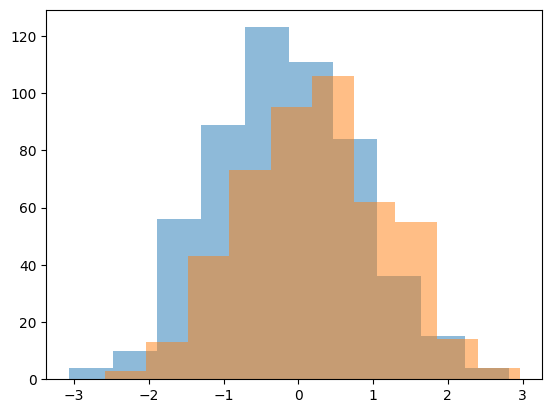

In [33]:
plt.hist(data_feature.query('T == 0')['X3'], alpha=0.5)
plt.hist(data_feature.query('T == 1')['X3'], alpha=0.5)

In [34]:
np.mean(data_feature.query('T == 0').iloc[:,0:3], 0)

X1   -0.278712
X2   -0.206280
X3   -0.176002
dtype: float64

In [35]:
np.mean(data_feature.query('T == 1').iloc[:,0:3], 0)

X1    0.264975
X2    0.246356
X3    0.218197
dtype: float64

In [36]:
np.mean(data_feature.query('T == 1').iloc[:,0:3], 0) - np.mean(data_feature.query('T == 0').iloc[:,0:3], 0)

X1    0.543687
X2    0.452636
X3    0.394199
dtype: float64